In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import seaborn as sns

%matplotlib inline

## read in the data

In [29]:
data = pd.read_csv('youtube-comments.csv')

In [30]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w


## cleaning the text

In [31]:
def cleaner(text):
    '''Function to clean the text data and prep for further analysis'''
    stops = set(stopwords.words("english"))     # Creating a set of Stopwords
    p_stemmer = PorterStemmer()                 # Creating the stemmer model
    text = re.sub("[^a-zA-Z]"," ",text)          # Removes punctuation
    text = text.split()                          # Splits the data into individual words 
    text = [w for w in text if not w in stops]   # Removes stopwords
    text = [p_stemmer.stem(i) for i in text]     # Stemming (reducing words to their root)
    return ' '.join(text)

In [32]:
data['clean'] = data['comment'].apply(cleaner)

In [33]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id,clean
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,What lucki guy got celebr birthday concert bil...
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,Love
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,american even knew corden sever year ago
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,birthday nd well support west ham
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,OMG IM CRi


## using tf-idf to convert the clean comments to a matrix of freq's

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

In [35]:
vectorizer = TfidfVectorizer(lowercase=False,
                             analyzer=u'word',
                             ngram_range=(1, 3),
                             stop_words='english',
                             binary=False,
                             norm=u'l2', 
                             use_idf=True, 
                             smooth_idf=True, 
                             sublinear_tf=True)
X = vectorizer.fit_transform(data.clean)

In [36]:
X.shape

(3935, 54000)

## creating labels

In [37]:
le = preprocessing.LabelEncoder()
le.fit(data.troll.values)
Y = le.transform(data.troll.values) 

## defining a classifier function

the fact that only 10% of the data is trolls means that maybe an anamoly detection approach would perform better, this is taken care of by giving the classifier the flag class_weight='balanced' that ensures a balanced sampling of the input data

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def model_rfc(X, Y, troll):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)
    
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    clf.fit(X_train, y_train)
    clf_probs = np.dot(clf.predict_proba(X_test)>0.5, np.array([0, 1]))
    
    score = confusion_matrix(y_test, clf_probs)
    
    print('confidence matrix:')
    print(score)
    plt.bar(range(X.shape[1]), clf.feature_importances_)
    
    clf_labels = np.dot(clf.predict_proba(X)>0.5, np.array([0, 1]))
    print('False Positives:')
    print('================')
    print(data['comment'][(clf_labels==1) & (troll==0)])
    print('False Negatives:')
    print('================')
    print(data['comment'][(clf_labels==0) & (troll==1)])
    
    return 

## dimensionality reduction

tf-idf vectorizer gives around 5500 words (columns) and that's more than the number of rows, and since most words are redundant anyway it is important to reduce the dimensionality of the problem

### Variance Threshold 

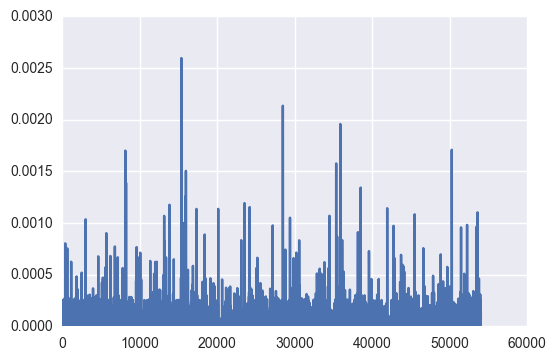

In [39]:
plt.plot(np.var(X.toarray(), axis=0))

In [40]:
from sklearn.feature_selection import VarianceThreshold 

In [41]:
sel = VarianceThreshold(threshold=0.0005)
X_var = sel.fit_transform(X)

In [42]:
X_var.shape

(3935, 83)

In [71]:
sel.inverse_transform(X_var).toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### PCA

In [43]:
from sklearn import decomposition

In [44]:
%%time

pca = decomposition.PCA(n_components=100)
pca.fit(X.toarray())
#data_pca = pca.transform(X)

Wall time: 33 s


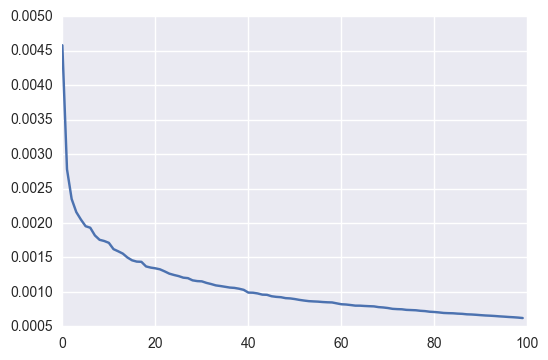

In [45]:
plt.plot(pca.explained_variance_ratio_)

In [46]:
%%time

pca = decomposition.PCA(n_components=10)
pca.fit(X.toarray())
X_pca = pca.transform(X.toarray())

Wall time: 16.2 s


## classifying using var threshold

confidence matrix:
[[686  18]
 [ 67  16]]
False Positives:
156                                          wwe is fake﻿
186                                                   No﻿
288     If the 10 Commandments Were Written Today it w...
354                            whooooooooopie fucking do﻿
435                                                  wtf﻿
766                                                  wtf﻿
905     I think she wanted to kill her self she couldn...
1533                           this is fucking hilarious﻿
1537                             hahahaaaaa  Good video!﻿
1539                                   He&#39;s a wizard﻿
1767                               he looks like zoom!!!﻿
1925                                      ohhhhhhhh shit﻿
1965                         All these jokes are so shit﻿
1973                                          Holy shit!﻿
2600                               Wtf the stepped on it﻿
2640                               what the fuck is that﻿
2660         

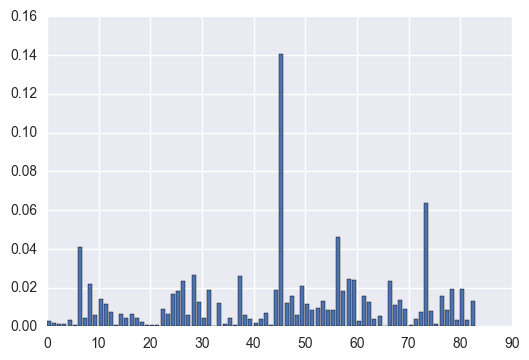

In [69]:
model_rfc(X_var, Y, data.troll)

## classifying using the result of PCA

confidence matrix:
[[710   6]
 [ 65   6]]
False Positives:
186                                                   No﻿
435                                                  wtf﻿
766                                                  wtf﻿
2574                      ahahah Scots ate fucking funny﻿
2592      Dude that&#39;s fucking sad. Rip little angel.﻿
2640                               what the fuck is that﻿
2656    Why so many people making jokes about this, th...
2660                                     Fucking bogging﻿
2815                                       fucking 10/10﻿
2829                                                 Wtf﻿
3430           He can stay out of mma dirty juice monkey﻿
3759    all you dumb bitches who said nate was going t...
Name: comment, dtype: object
False Negatives:
308                                               nigger﻿
464              Another shitty female lead action movie﻿
466     Dafaq is this shit? Its exactly the same as th...
738                      

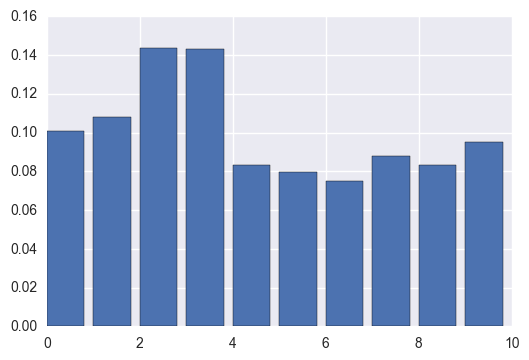

In [66]:
model_rfc(X_pca, Y, data.troll)

## creating new features based on the length of the comment etc

In [48]:
def bad_word_counter(text):
    bad_words = pd.read_csv('google_badlist.txt', header=None).values
    return len([w for w in text.split() if w in bad_words])

In [49]:
def transform(documents):
    ## some handcrafted features!
    n_words = [len(c.split()) for c in documents]
    n_chars = [len(c) for c in documents]
    # number of uppercase words
    allcaps = [np.sum([w.isupper() for w in comment.split()])
           for comment in documents]
    # longest word
    max_word_len = [np.max([len(w) for w in c.split()]) for c in documents]
    # average word length
    mean_word_len = [np.mean([len(w) for w in c.split()])
                                        for c in documents]
    # number of google badwords:
    n_bad = [bad_word_counter(c) for c in documents]
    exclamation = [c.count("!") for c in documents]
    addressing = [c.count("@") for c in documents]
    spaces = [c.count(" ") for c in documents]

    allcaps_ratio = np.array(allcaps) / np.array(n_words, dtype=np.float)
    bad_ratio = np.array(n_bad) / np.array(n_words, dtype=np.float)
    
    counts = np.array([n_words, n_chars, allcaps, max_word_len,
                       mean_word_len, exclamation, addressing, spaces,
                       n_bad]).T
    ratios = np.array([allcaps_ratio, bad_ratio]).T

    return counts, ratios

## classifying based on the features like the length of the comment etc

In [50]:
from sklearn.preprocessing import scale

In [51]:
counts, ratios = transform(data.comment)

In [52]:
np.var(counts, axis=0)

array([  4.88872874e+02,   1.55130994e+04,   1.06268625e+01,
         1.83229048e+02,   9.56477901e+00,   7.36037612e+00,
         2.79019454e-03,   6.30713697e+02,   1.81380986e-01])

In [53]:
np.var(ratios, axis=0)

array([ 0.03757508,  0.00188708])

In [56]:
X_ext = scale(np.concatenate((counts, ratios), axis=1), with_mean=True, axis=0)

confidence matrix:
[[654  54]
 [ 68  11]]
False Positives:
2       no americans even knew who corden was several ...
3       my birthday was the 22nd as well and we both s...
22                                              nausious﻿
32                             has james put on weight ?﻿
34                        Sorry, James Corden not Conrad﻿
44                                                 Beaut﻿
50                                                 Hello﻿
53      can&#39;t wait to see you guys this december i...
63                               Maine Mendoza was here.﻿
68                   great song :)) always love Coldplay﻿
80      King James Corden<br />he absolutely smashed it.﻿
109                                        Word of Tanks﻿
119                                    But still though?﻿
142               have braun stroman vs the beast lesnar﻿
147       brock lesnar is probably gonna try and rake it﻿
183                          Did you see Grim And Dohup?﻿
195          

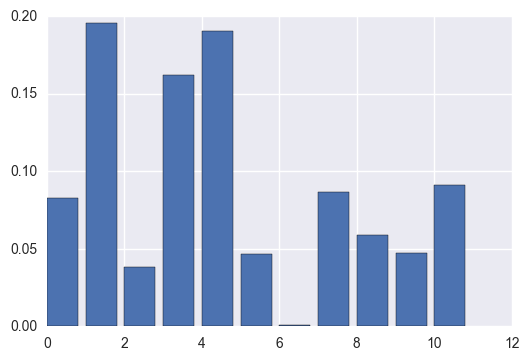

In [57]:
model_rfc(X_ext, Y, data.troll)

## classifying based on generated features

confidence matrix:
[[701   3]
 [ 77   6]]
False Positives:
186                                                   No﻿
2270    why has amber rose got a show? talentless tras...
2656    Why so many people making jokes about this, th...
2829                                                 Wtf﻿
Name: comment, dtype: object
False Negatives:
17      This clown is like shit on a field. Unfunny fa...
236       ehhh fine...i&#39;ll give ya a like..assholes.﻿
322                            FUCK YOU CHINA WE GOT 2ND﻿
592     Why is this kind of stuff on YouTube. It&#39;s...
774     R.I.P to that 20seconds Ill never get back.  I...
777                                           goofy fuck﻿
895     I hope that bitch drowns, that black lives mat...
898     I would love to ram the big man right up her h...
902                                       TMZ is so shit﻿
910                                         Fuck you TZM﻿
914                          Man she&#39;s ugly as fuck.﻿
916                      

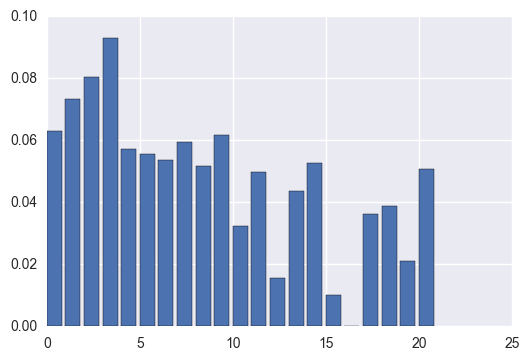

In [59]:
model_rfc(np.concatenate((X_pca, X_ext), axis=1), Y, data.troll)

## visualizing some of the features

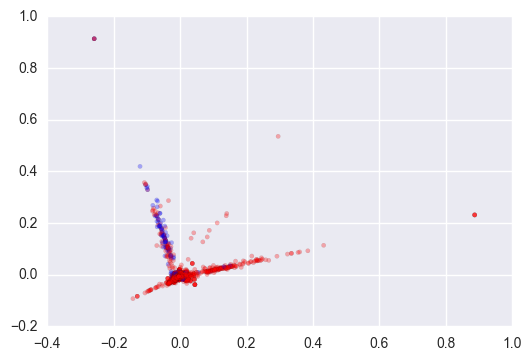

In [60]:
colors = ['r', 'b']
label_colors = [colors[lab] for lab in data.troll.values]

plt.scatter(X_pca[:,3], X_pca[:,2], 
            s=10,
            lw=0.1,
            c=label_colors,
            alpha=0.3)

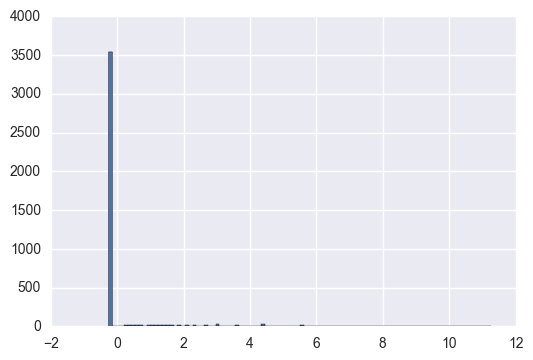

In [61]:
a = plt.hist(X_ext[:,-1], bins=100)

## using isolation forest

In [62]:
from sklearn.ensemble import IsolationForest

def model_ifc(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)
    clf = IsolationForest(n_estimators=100)
    clf.fit(X_train, y_train)
    clf_probs = clf.predict(X_test) < 0
    score = confusion_matrix(y_test, clf_probs)
    print(score)

In [63]:
model_ifc(X_pca, Y)

[[627  85]
 [ 66   9]]


# Questions
* does it make sense to do variance based feature selection when dealing with imbalanced label sizes?